# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [91]:
%pylab inline
import pandas as pd
import sklearn.model_selection as sm
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [92]:
train = pd.read_csv('train.csv')
train.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [93]:
y = train.iloc[:,-1:]
x = train.iloc[:,:-1]

In [94]:
y.price_range[y.price_range == 1] = 0 
y.price_range[y.price_range > 1] = 1 
y.head(10)

,price_range
0,0
1,1
2,1
3,1
4,0
5,0
6,1
7,0
8,0
9,0


Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [95]:
np.random.seed(42)
x_train, x_test, y_train, y_test = sm.train_test_split(x, y, test_size=0.3, random_state=42)
y_train = np.ravel(y_train)

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [96]:
import sklearn.preprocessing as sp

scaler = sp.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [97]:
import sklearn.linear_model as sl

logit = sl.LogisticRegression()
logit.fit(x_train, y_train)
y_pred = logit.predict_proba(x_test)
pos_feat = np.array([i[1] for i in y_pred])

In [98]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import accuracy_score

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.999733306664
Accuracy:  0.983333333333


#### ОТВЕТ: 
Получается, что результат предсказывается очень хорошо.

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

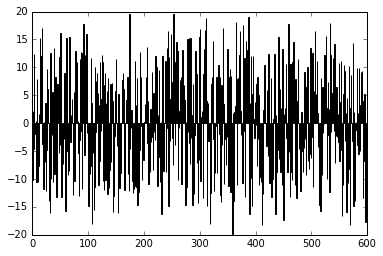

In [99]:
bx = logit.intercept_ + np.dot(x_test, logit.coef_.T)
plt.bar([x for x in range(len(bx))], bx)
plt.show()

### Ответ:
1) Значения в основном и интервале (0, -3) из-за w0 (он отрицателен и сдвигает значения произведения вниз)

2) Это как-то не похоже на вероятности, очевидно, что с этими данными надо сделать что-то еще, чтобы ужать их хотя бы в (0,1)

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

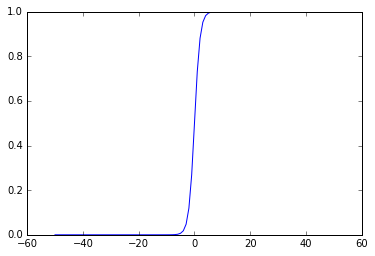

In [100]:
import math
sigx = np.array([x for x in range(-50,50)])
sigy = 1 / (1 + np.exp(-sigx))
plt.plot(sigx, sigy)
plt.show()

# область значения (0,1)
# значит, она подходит, чтобы преобразовать значения во что-то похожее на вероятности

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [101]:
by = 1 / (1 + np.exp(-1*bx))

x = by == y_pred

x.sum(axis=0)
# второй столбик равен by - все получилось верно!

array([  0, 600])

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

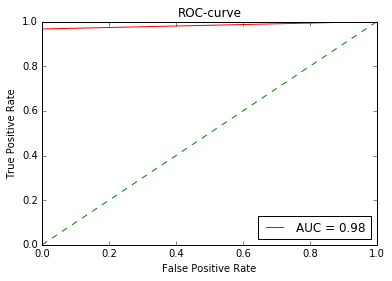

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test, pos_feat)
roc_auc = auc(fpr, tpr)

plt.title('ROC-curve')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [103]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

In [104]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [159]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=1)
DTC.fit(x_train, y_train)
y_pred = DTC.predict_proba(x_test)

pos_feat = np.array([i[1] for i in y_pred])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.939927326066
Accuracy:  0.94


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [150]:
summary = np.zeros((600, 2))

DTC = DecisionTreeClassifier(random_state=1)
for i in range(100):
    DTC.fit(x_train, y_train)
    summary += DTC.predict_proba(x_test)

result = summary / 100

pos_feat = np.array([i[1] for i in result])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.939927326066
Accuracy:  0.94


### Ответ

Качество практически не изменилось, так как бэггинг без бутстрепа и без каких-либо случайностей в построении дерева будет давать одинаковые деревья и их усреднение никак не будет отличаться. 

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [151]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

summary = np.zeros((600, 2))

DTC = DecisionTreeClassifier(random_state=1)

for i in range(100):
    choice = np.random.randint(0, 1400, size=len(x_train))
    x_train_boot = [x_train[n] for n in choice]
    y_train_boot = [y_train[n] for n in choice]
    DTC.fit(x_train_boot, y_train_boot)
    summary2 += DTC.predict_proba(x_test)

result = summary / 100

pos_feat = np.array([i[1] for i in result])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.992604816037
Accuracy:  0.956666666667


### Ответ:
Качество сильно улучшилось засчет бутстрапа

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [157]:
np.random.seed(123) # для воспроизводимости построения случайных подмножеств признаков

max_features = int(sqrt(np.shape(x_train)[1]))

DTC = DecisionTreeClassifier(max_features=max_features)
DTC.fit(x_train, y_train)
y_pred = DTC.predict_proba(x_test)

pos_feat = np.array([i[1] for i in y_pred])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.840084008401
Accuracy:  0.84


### Ответ:

Качество стало сильно хуже.

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [156]:
max_features = int(sqrt(np.shape(x_train)[1]))

np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

summary = np.zeros((600, 2))

DTC = DecisionTreeClassifier(random_state=1, max_features=max_features)

for i in range(100):
    choice = np.random.randint(0, 1400, size=len(x_train))
    x_train_boot = [x_train[n] for n in choice]
    y_train_boot = [y_train[n] for n in choice]
    DTC.fit(x_train_boot, y_train_boot)
    summary += DTC.predict_proba(x_test)

result = summary / 100

pos_feat = np.array([i[1] for i in result])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

ROC-AUC:  0.991360247136
Accuracy:  0.956666666667


### Ответ:

Качество приблизилось к максимальному засчет сочетания методов.

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [158]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)

forest.fit(x_train, y_train)

y_pred = forest.predict_proba(x_test)

pos_feat = np.array([i[1] for i in y_pred])

print('ROC-AUC: ', roc_auc_score(y_test, pos_feat))
pos_feat = [1 if i > 0.5 else 0 for i in pos_feat]
print('Accuracy: ', accuracy_score(y_test, pos_feat))

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

ROC-AUC:  0.993793823827
Accuracy:  0.961666666667


### Ответ:

Качество почти такое же, это хорошо.

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

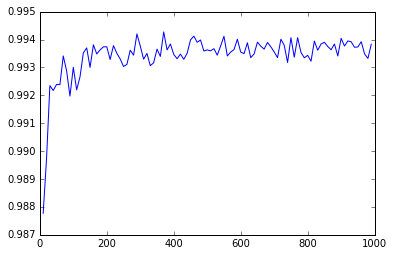

In [85]:
roc_aucs = []
x = [x for x in range(10, 1000, 10)]

for i in x:
    forest = RandomForestClassifier(n_estimators=i)

    forest.fit(x_train, y_train)

    y_pred = forest.predict_proba(x_test)
    
    pos_feat = np.array([i[1] for i in y_pred])

    roc_aucs.append(roc_auc_score(y_test, pos_feat))
    
plt.plot(x, roc_aucs)
plt.show()

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Ответ:

Количество деревьев влияет на качество, но после примерно 300 деревьев повышения качества не происходит.

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

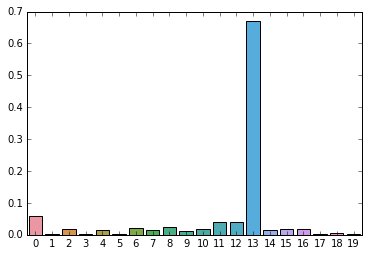

In [86]:
import seaborn as sn

data = train.iloc[:,:-1]
feat= forest.feature_importances_
#tips = sn.load_dataset("train.csv")
tips = data.columns.values.tolist()
sn.barplot([x for x in range(len(feat))], feat, data=data.iloc[:,:-1])

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- получается, что бутстреп+бэггинг может сильно улучшить качество на одной и тоже выборке. Кажется, что это хороших выход, когда выборка ограничена
- логистическая регрессия больше подходит для задач классификации, так как ее выход засчет функции сигмоиды похож на вероятность. Линейная регрессия работает не так.
- я научилась строить логистическую регрессию, беггинг и бутстреп вручную, это было занятно и улучшило понимание происходящего